<a href="https://colab.research.google.com/github/0201shj/CNN-Cats-Dogs/blob/main/1_cnn_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset-CNN

In [ ]:
!unzip dogs_cats.zip

In [2]:
import keras
keras.__version__

'2.4.3'

In [3]:
import glob
import numpy as np
import os
import shutil
#from utils import log_progress

np.random.seed(42)

In [4]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12514)

In [6]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [7]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in log_progress(train_files, name='Training Images'):
    shutil.copy(fn, train_dir)

for fn in log_progress(validate_files, name='Validation Images'):
    shutil.copy(fn, val_dir)
    
for fn in log_progress(test_files, name='Test Images'):
    shutil.copy(fn, test_dir)

# Basic CNN

In [8]:
%matplotlib inline

In [9]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [10]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [11]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

(150, 150, 3)


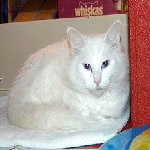

In [12]:
print(train_imgs[99].shape)
array_to_img(train_imgs[99])

In [13]:
batch_size = 50
num_classes = 2
epochs = 150
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog'] [1 1 0 0 1 1 0 1 1 1]


In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [15]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [16]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

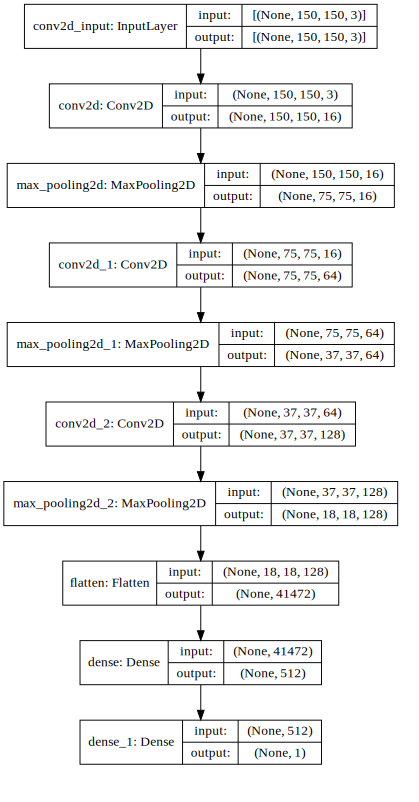

In [19]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB', dpi=69).create(prog='dot', format='svg'))

In [20]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/150
60/60 [==============================] - 6s 47ms/step - loss: 2.9853 - accuracy: 0.5048 - val_loss: 0.6753 - val_accuracy: 0.5640
Epoch 2/150
60/60 [==============================] - 2s 42ms/step - loss: 0.7112 - accuracy: 0.5856 - val_loss: 0.6706 - val_accuracy: 0.6030
Epoch 3/150
60/60 [==============================] - 2s 41ms/step - loss: 0.6522 - accuracy: 0.6317 - val_loss: 0.5995 - val_accuracy: 0.6950
Epoch 4/150
60/60 [==============================] - 3s 42ms/step - loss: 0.5978 - accuracy: 0.7099 - val_loss: 0.6266 - val_accuracy: 0.6480
Epoch 5/150
60/60 [==============================] - 2s 42ms/step - loss: 0.5077 - accuracy: 0.7471 - val_loss: 0.5944 - val_accuracy: 0.7010
Epoch 6/150
60/60 [==============================] - 2s 41ms/step - loss: 0.4298 - accuracy: 0.7893 - val_loss: 0.6264 - val_accuracy: 0.7080
Epoch 7/150
60/60 [==============================] - 2s 41ms/step - loss: 0.3306 - accuracy: 0.8460 - val_loss: 0.6416 - val_accuracy: 0.7250
Epoch 

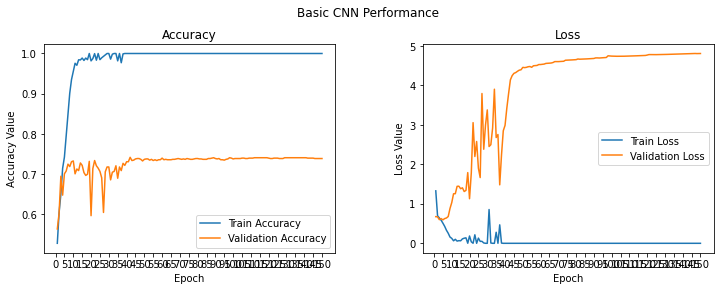

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 151))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 151, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 151, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [24]:
model.save('1-basic-cnn.h5')